In [ ]:
!pip install ultralytics

from ultralytics import YOLO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 749.6/749.6 kB 4.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
# data time

import os

dataset_dir = 'hagrid'
os.makedirs(dataset_dir, exist_ok=True)

!gdown 1JGaS7kbeer8QqEeiSP3UcgE0npJzPTFK -O hagrid/hagrid.zip

import zipfile
zip_file_path = os.path.join('hagrid', 'hagrid.zip')

# extract downloaded zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

os.remove(zip_file_path)

%rm -rf hagrid/__MACOSX/

hagrid_micro_dir = os.path.join(dataset_dir, 'HG_micro_3class')
%cat {hagrid_micro_dir}/data.yaml

Downloading...
From (original): https://drive.google.com/uc?id=1JGaS7kbeer8QqEeiSP3UcgE0npJzPTFK
From (redirected): https://drive.google.com/uc?id=1JGaS7kbeer8QqEeiSP3UcgE0npJzPTFK&confirm=t&uuid=7f09094b-7d21-4ca4-a420-d38f2d85d80b
To: /content/hagrid/hagrid.zip
100% 1.90G/1.90G [00:26<00:00, 71.8MB/s]
train: hagrid/HG_micro_3class/train/images
val: hagrid/HG_micro_3class/valid/images
test: hagrid/HG_micro_3class/test/images

nc: 3
names: [fist,palm,no_gesture]


In [ ]:
import os

def count_jpg_files(directory):
    jpg_count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.jpg'):
                jpg_count += 1
    return jpg_count

# Example usage:
directory_path = 'hagrid'
jpg_count = count_jpg_files(directory_path)
print("Number of JPG files:", jpg_count)


Number of JPG files: 1400


In [ ]:
!pip install Pillow
!pip install albumentations


agumentation


In [ ]:
def pixelate_and_blur(image):
    # Generate random factor for pixelation (1, 2, or 3)
    pixelation_factor = random.choices([1, 2, 3], weights=[0.5, 0.25, 0.25])[0]


    # Generate random kernel size for blur
    kernel_size = random.choices([1,9,15], weights=[0.5, 0.25, 0.25])[0]

    # Pixelate the image
    pixelated_image = pixelate(image, pixelation_factor)

    # Apply motion blur
    blurred_image = motion_blur(pixelated_image, kernel_size)

    return blurred_image

def pixelate(image, factor):
    # Calculate the dimensions of the pixelated image
    height, width = image.shape[:2]
    new_height = height // factor
    new_width = width // factor

    # Resize the image to smaller dimensions
    small_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_NEAREST)

    # Resize the smaller image back to original dimensions
    pixelated_image = cv2.resize(small_image, (width, height), interpolation=cv2.INTER_NEAREST)

    return pixelated_image

def motion_blur(image, kernel_size):
    # Create motion blur kernel
    kernel_motion_blur = np.zeros((kernel_size, kernel_size))
    kernel_motion_blur[int((kernel_size-1)/2), :] = np.ones(kernel_size)
    kernel_motion_blur /= kernel_size

    # Apply the kernel to the image
    blurred = cv2.filter2D(image, -1, kernel_motion_blur)

    return blurred


In [ ]:
import os
import cv2
from albumentations import Compose, Rotate
from albumentations.core.bbox_utils import convert_bbox_to_albumentations
from albumentations.core.bbox_utils import convert_bbox_from_albumentations
import random
import numpy as np

In [ ]:
def rotate_images_and_bboxes (image_dir,label_dir):


  # Function to read bounding boxes from label file
  def read_bboxes_from_file(label_path):
      with open(label_path, 'r') as file:
          lines = file.readlines()
          bboxes = []
          for line in lines:
              parts = line.strip().split()
              parts = [float(x) for x in parts]
              bboxes.append(parts)
          return bboxes

  # Function to write bounding boxes to label file
  def write_bboxes_to_file(label_path, bboxes):
      with open(label_path, 'w') as file:
          for bbox in bboxes:
              line = ' '.join([str(int(bbox[0]))] + [str(coord) for coord in bbox[1:]]) + '\n'
              file.write(line)



  # Define the possible rotation angles



  # Iterate over each image file in the directory
  for filename in os.listdir(image_dir):
      if filename.endswith('.jpg') or filename.endswith('.jpeg'):
          # Load the image
          image_path = os.path.join(image_dir, filename)
          image = cv2.imread(image_path)
          image_height, image_width = image.shape[:2]

          # Load bounding boxes from label file
          label_filename = os.path.splitext(filename)[0] + '.txt'
          label_path = os.path.join(label_dir, label_filename)
          bboxes_yolo = read_bboxes_from_file(label_path)

          class_ids = [int(bbox[0]) for bbox in bboxes_yolo]

          # Convert YOLO format bounding boxes to Albumentations format
          bboxes_albumentations = [convert_bbox_to_albumentations(bbox[1:], source_format='yolo', rows=image_height, cols=image_width)
                                  for bbox in bboxes_yolo]

          # Define the rotation angle (in degrees)
          rotation_angle = random.choice([0, 22, 45, 60, 300, 315, 338])

          augmentation_pipeline = Compose([
              Rotate(limit=(rotation_angle,rotation_angle), interpolation=cv2.INTER_NEAREST, border_mode=cv2.BORDER_CONSTANT, value=0, p=1)
          ], bbox_params={'format': 'albumentations', 'label_fields': ['category_id']})

          # Apply augmentation to the image and bounding boxes
          augmented = augmentation_pipeline(image=image, bboxes=bboxes_albumentations, category_id=[0]*len(bboxes_albumentations))
          augmented_image = augmented['image']
          augmented_bboxes = augmented['bboxes']

          # Update bounding box coordinates in the label file
          for i, bbox in enumerate(augmented_bboxes):
              # Convert the bounding box to YOLO format
              bbox_yolo = convert_bbox_from_albumentations(bbox, target_format='yolo', rows=image_height, cols=image_width)

              bbox_yolo_with_class_id = [class_ids[i]] + list(bbox_yolo)

              # Update the bounding box coordinates in YOLO format
              bboxes_yolo[i] = bbox_yolo_with_class_id
              #print(bboxes_yolo[i])

          # ADD ADITIONAL BLUR AND PIXELATION
          augmented_image = pixelate_and_blur(augmented_image)

          # Save the augmented image
          cv2.imwrite(os.path.join(image_dir, filename), augmented_image)

          # Write the updated bounding boxes to the label file
          write_bboxes_to_file(label_path, bboxes_yolo)

          #print(f'Augmented image and updated label saved: {filename}')

In [ ]:
  # # Directory containing images
  # image_dir = 'hagrid/HG_micro_3class/train/images/'
  # # Directory containing label files
  # label_dir = 'hagrid/HG_micro_3class/train/labels/'
rotate_images_and_bboxes ('hagrid/HG_micro_3class/train/images/','hagrid/HG_micro_3class/train/labels/')
rotate_images_and_bboxes ('hagrid/HG_micro_3class/test/images/','hagrid/HG_micro_3class/test/labels/')
rotate_images_and_bboxes ('hagrid/HG_micro_3class/valid/images/','hagrid/HG_micro_3class/valid/labels/')

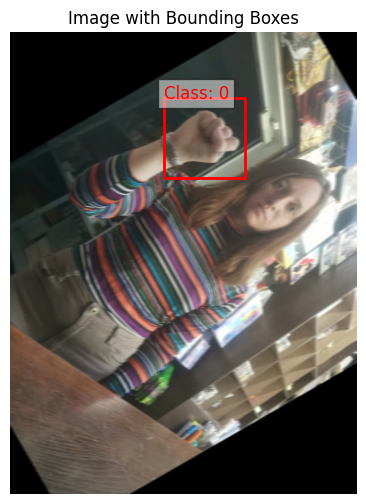

In [ ]:
import cv2
import matplotlib.pyplot as plt

def show_image_with_bboxes(image_path, label_path):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Read bounding boxes from the label file
    with open(label_path, 'r') as file:
        lines = file.readlines()
        bboxes = []
        for line in lines:
            parts = line.strip().split()
            class_label = int(parts[0])
            bbox = list(map(float, parts[1:]))
            bboxes.append((class_label, bbox))

    # Display the image with bounding boxes
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title('Image with Bounding Boxes')

    for class_label, bbox in bboxes:
        x, y, w, h = bbox
        xmin, ymin = int((x - w / 2) * image.shape[1]), int((y - h / 2) * image.shape[0])
        xmax, ymax = int((x + w / 2) * image.shape[1]), int((y + h / 2) * image.shape[0])
        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], color='red', linewidth=2)
        plt.text(xmin, ymin, f'Class: {class_label}', color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.axis('off')
    plt.show()

# Example usage:
image_path = 'hagrid/HG_micro_3class/train/images/0a935091-5b6b-4fd5-bc01-f7d3a240c09a.jpg'
label_path = 'hagrid/HG_micro_3class/train/labels/0a935091-5b6b-4fd5-bc01-f7d3a240c09a.txt'
show_image_with_bboxes(image_path, label_path)



In [ ]:
# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print("Current working directory:", current_directory)

Current working directory: /content


In [ ]:
# Fixing yaml file

import yaml

# Define the new values for the first three lines
new_lines = [
    "train: /content/hagrid/HG_micro_3class/train\n",
    "val: /content/hagrid/HG_micro_3class/valid\n",
    "test: /content/hagrid/HG_micro_3class/test\n"
]

yaml_file_path = "hagrid/HG_micro_3class/data.yaml"

# Read the existing content of the YAML file
with open(yaml_file_path, 'r') as file:
    yaml_content = file.readlines()

# Modify the first three lines with the new values
yaml_content[:3] = new_lines

# Write the modified content back to the YAML file
with open(yaml_file_path, 'w') as file:
    file.writelines(yaml_content)

print("First three lines of the YAML file have been updated.")

First three lines of the YAML file have been updated.


In [ ]:
!ls

hagrid	sample_data


In [ ]:
# model time

model = YOLO('yolov8s.pt')
results = model.train(data='/content/hagrid/HG_micro_3class/data.yaml', epochs=20, imgsz=416, batch=16, cache=True,optimizer='SGD', lr0 = 0.001,weight_decay=0.0005)




GROUND TRUTH DATA:


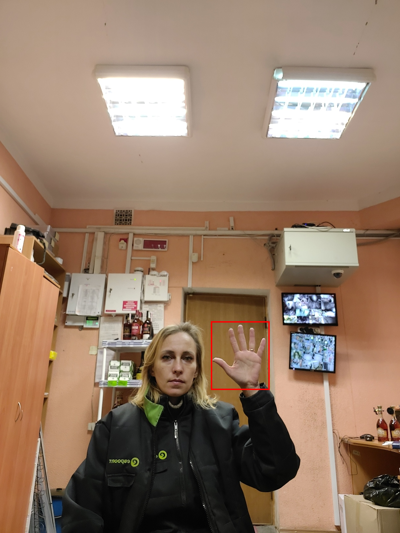

In [ ]:
from PIL import Image as PILImage, ImageDraw

# first, display our ground truth data
print("GROUND TRUTH DATA:")
test_image = '/content/hagrid/HG_micro_3class/test/images/00a07a41-3c4e-41ec-91ec-8bc39baa30f0.jpg'
label_file = '/content/hagrid/HG_micro_3class/test/labels/00a07a41-3c4e-41ec-91ec-8bc39baa30f0.txt'



def draw_bounding_box(image_path, labels_path, display_width=400):
    image = PILImage.open(image_path)
    draw = ImageDraw.Draw(image)

    # labels from file
    with open(labels_path, 'r') as f:
        labels = f.readlines()
        for label in labels:
            # class, xc, yc, w, h
            class_, relative_cx, relative_cy, w, h = map(float, label.split())
            width, height = image.size

            # relative coordinates to absolute coordinates
            cx = int(relative_cx * width)
            cy = int(relative_cy * height)

            x1 = cx - w * width / 2
            y1 = cy - h * height / 2
            x2 = cx + w * width / 2
            y2 = cy + h * height / 2

            # bounding box
            draw.rectangle([x1, y1, x2, y2], outline='red', width = 5)

     # Resize image for display
    aspect_ratio = image.size[0] / image.size[1]
    display_height = int(display_width / aspect_ratio)
    image = image.resize((display_width, display_height))

    display(image)

draw_bounding_box(test_image, label_file)

In [ ]:
prediction = model('/content/hagrid/HG_micro_3class/test/images/00dbe141-656b-4937-a33e-7866c66498aa.jpg')



image 1/1 /content/hagrid/HG_micro_3class/test/images/00dbe141-656b-4937-a33e-7866c66498aa.jpg: 416x320 1 palm, 74.3ms
Speed: 2.1ms preprocess, 74.3ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 320)


In [ ]:
for pred in prediction:
   x_min, y_min, x_max, y_max, confidence, maxClass = pred.boxes.data[0]
   print(x_min, y_min, x_max, y_max, confidence, maxClass)

tensor(917.8783, device='cuda:0') tensor(526.8926, device='cuda:0') tensor(1358.0688, device='cuda:0') tensor(978.7850, device='cuda:0') tensor(0.8865, device='cuda:0') tensor(1., device='cuda:0')
